In [1]:
# -*- coding: utf-8 -*-
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
figsize(12.5, 4)

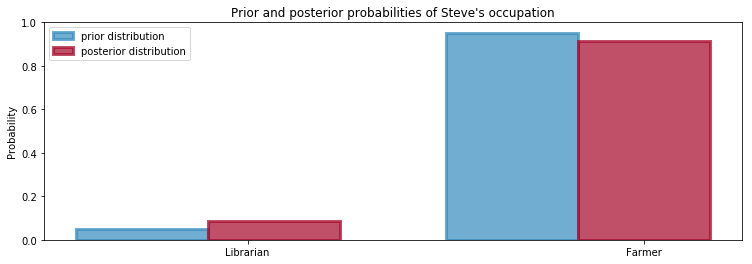

In [2]:
colors = ['#348ABD', '#A60628']
prior = [1/21., 20/21.]
posterior = [0.087, 1 - 0.087]
# 事前確率
plt.bar([0, .7], prior, alpha=0.70, width=0.25,
           color=colors[0], label='prior distribution',
           lw='3', edgecolor='#348ABD')
# 事後確率
plt.bar([0+0.25, .7+0.25], posterior, alpha=0.7,
           width=0.25, color=colors[1],
           label='posterior distribution',
           lw='3', edgecolor=colors[1])

plt.xticks([0.20, 0.95], ['Librarian', 'Farmer'])
plt.ylabel('Probability')
plt.legend(loc='upper left')
plt.title("Prior and posterior probabilities of Steve's occupation")

### 離散の場合

ポアソン分布
$$
P(Z = k) = \frac{\lambda^k e^{-\lambda}}{k!} \\ k = 0, 1, 2, ...
$$

ここで$\lambda$は正の実数

- $Z \sim Poi(\lambda)$
- 期待値は $E[Z|\lambda] = \lambda$

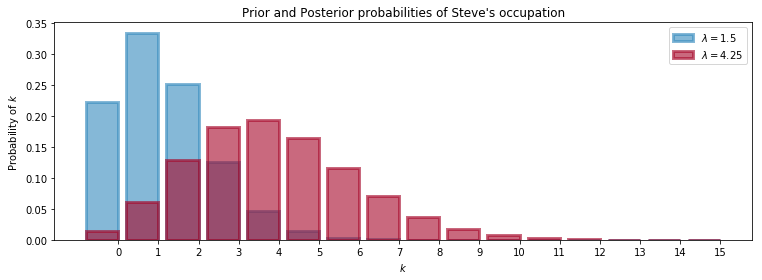

In [3]:
import scipy.stats as stats

poi = stats.poisson
lambda_ = [1.5, 4.25]
colors = ['#348ABD', '#A60628']

a = np.arange(16)
plt.bar(a, poi.pmf(a, lambda_[0]), color=colors[0],
           label='$\lambda = {}$'.format(lambda_[0]),
           alpha=0.60, edgecolor=colors[0], lw='3')
plt.bar(a, poi.pmf(a, lambda_[1]), color=colors[1],
           label='$\lambda = {}$'.format(lambda_[1]),
           alpha=0.60, edgecolor=colors[1], lw='3')
plt.xticks(a+0.4, a)
plt.legend()
plt.ylabel('Probability of $k$')
plt.xlabel('$k$')
plt.title("Prior and Posterior probabilities of Steve's occupation")

### 連続の場合
指数分布

$$
f_z(z|\lambda) = \lambda e^{-\lambda z} \\
z \geq 0
$$

- $Z \sim Exp(\lambda)$
- $E[Z|\lambda] = \frac{1}{\lambda}$

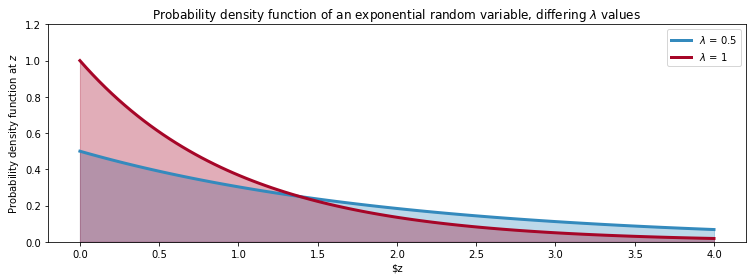

In [6]:
a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 1]

for l, c in zip(lambda_, colors):
    plt.plot(a, expo.pdf(a, scale=1. / l),
             lw=3, color=c, label='$\lambda$ = {}'.format(l))
    plt.fill_between(a, expo.pdf(a, scale=1. / l),
                    color=c, alpha=.33)

plt.legend()
plt.ylabel('Probability density function at $z$')
plt.xlabel('$z')
plt.ylim(0, 1.2)
plt.title('Probability density function of an exponential random variable, differing $\lambda$ values')

In [7]:
import os
os.makedirs('data', exist_ok=True)

from urllib.request import urlretrieve
urlretrieve('http://git.io/vXTVC', os.path.join('data', 'textdata.csv'))

('data\\textdata.csv', <http.client.HTTPMessage at 0xa217ef0>)

(0, 74)

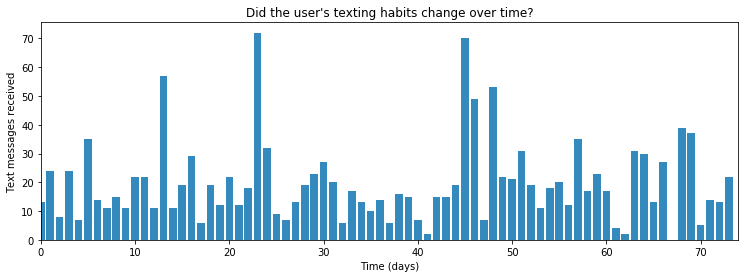

In [10]:
count_data = np.loadtxt('data/textdata.csv')
plt.bar(np.arange(len(count_data)), count_data, color='#348ABD')
plt.xlabel('Time (days)')
plt.ylabel('Text messages received')
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, len(count_data))

このような計数データはポアソン分布で表すことができる
$$
C_i \sim Poi(\lambda)
$$

- 急激な変化点を$\tau$とすると、$t<\tau$のとき$\lambda_1$, $t\geq\tau$のとき$\lambda_2$と定義できる
- 正の実数である$\lambda_1, \lambda_2$の事前分布は指数分布とする
- 指数分布もパラメータがあるがハイパーパラメータとする $\lambda_1 \sim Exp(\alpha)$ と $\lambda_2 \sim Exp(\alpha)$

- 計数データの平均をとって、逆数にする
$$
\frac{1}{N}\sum C_i \approx E[\lambda|\alpha] = \frac{1}{\alpha}
$$

データには結構なばらつきがあるから、$\tau$の事前分布は一様分布とする

$$
\tau \sim DiscreteUniform(1, 70) \\
P(\tau = k) = \frac{1}{70}
$$


In [12]:
import pymc3 as pm
import theano.tensor as T

with pm.Model() as model:
    alpha = 1. / count_data.mean()
    
    lambda_1 = pm.Exponential('lambda_1', alpha)
    lambda_2 = pm.Exponential('lambda_2', alpha)
    
    tau = pm.DiscreteUniform('tau', lower=0, upper=len(count_data) - 1)

In [14]:
print(tau.random(), tau.random(), tau.random())

38 20 26


In [15]:
with model:
    idx = np.arange(len(count_data))
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

In [16]:
with model:
    observation = pm.Poisson('obs', lambda_, observed=count_data)

In [17]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
c:\users\owner\anaconda3\envs\py3\lib\site-packages\pymc3\sampling.py:231: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically '
c:\users\owner\anaconda3\envs\py3\lib\site-packages\pymc3\sampling.py:234: UserWarning: Automatic initialization is not supported for discrete variables. Ignoring init argument.
  warnings.warn('Automatic initialization is not supported '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2417.12it/s]


In [19]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

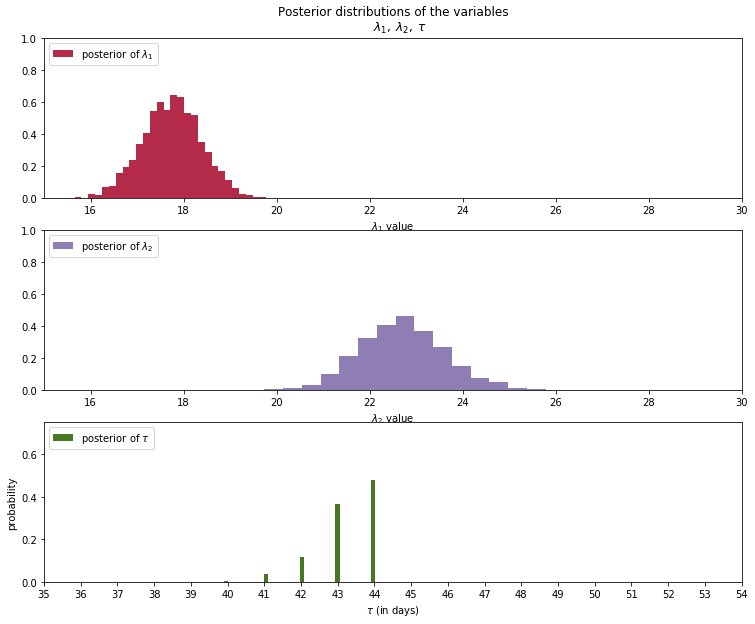

In [21]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=len(count_data), alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(len(count_data)))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");